# Importing Libraries

In [1]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing
from skimage.measure import label as skimage_label, regionprops
from skimage.morphology import remove_small_objects, remove_small_holes
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import cv2

## Dataset Path + Resize and Rotulation

In [2]:
ds_path = 'mpeg7_mod'

# Lista das pastas na pasta 'ds_path' (nomes das classes)
classes_list = os.listdir(ds_path)

# Lista com as imagens no dataset
image_list = []
# Lista com os rótulos das imagens
label_list = []

# Lista com os nomes das imagens
filename_list_ = []

# Percorre as classes do dataset
for classe in classes_list:

    # Listagem de todas as imagens na pasta daquela classe
    filename_list = os.listdir(os.path.join(ds_path, classe))

    # Percorre os arquivos na pasta atual
    for filename in filename_list:
        # Carrega a imagem
        img_temp = plt.imread(os.path.join(ds_path, classe, filename))

        # Redimensiona a imagem para 1/4 do tamanho original
        img_temp = transform.resize(img_temp, (img_temp.shape[0]//4, img_temp.shape[1]//4), anti_aliasing=True)

        # Adiciona a imagem a lista de imagens
        image_list.append(img_temp)

        # Adiciona o rótulo da imagem à lista de rótulos
        label_list.append(classe)

        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        filename_list_.append(filename)

In [3]:
# Coverte para numpy array
label_list = np.array(label_list)
# Lista com os rótulos das imagens
print(label_list)

['apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 

In [4]:
# Seleciona apenas as primeiras N imagens de cada classe
image_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i, class_name in enumerate(classes_list):
    print(i, class_name)
    # As 6 primeiras ocorrencias em que em label_list igual a class_name.
    # Imagem.
    image_list_temp += [image_list[j] for j in np.where(label_list==class_name)[0][:6]]
    # Nome do arquivo.
    filename_list_temp += [filename_list_[j] for j in np.where(label_list==class_name)[0][:6]]

0 apple
1 bat
2 beetle
3 bell
4 bird
5 bone


## Plotting Resize Images

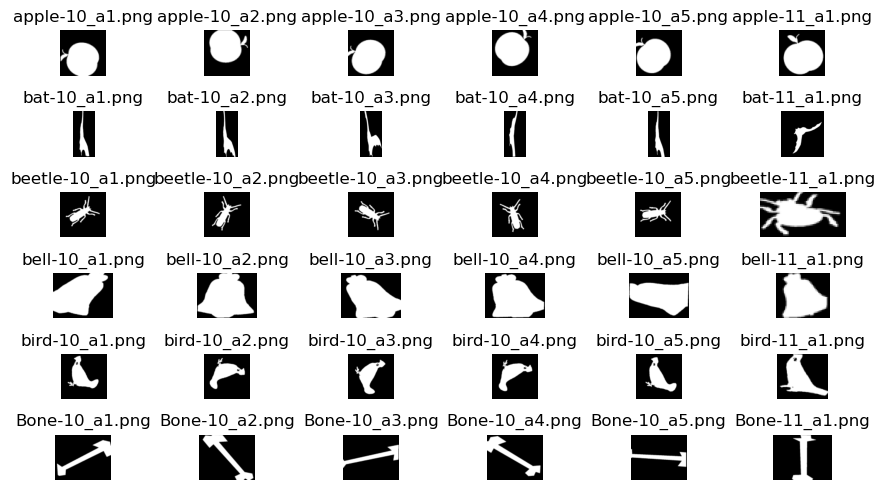

In [5]:
# Número de imagens
num_images = len(image_list_temp)

# Calcular as dimensões da grade
rows = math.ceil(num_images / 6)
cols = 6

# Criar a figura com grade ajustada
fig, ax = plt.subplots(rows, cols, figsize=(9, 5))

# Garantir que 'ax' seja bidimensional
if rows == 1:
    ax = ax[np.newaxis, :]  # Ajuste para uma única linha de subplots

# Iterar pelas imagens e títulos
for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    # Normalizar se necessário
    if image.max() > 1:  # Assumindo que já está na escala [0, 255]
        normalized_image = image
    else:  # Escala [0, 1]
        normalized_image = (image * 255).astype('uint8')

    # Plotar imagem
    ax[i // 6, i % 6].imshow(normalized_image, cmap='gray', vmin=0, vmax=255)
    ax[i // 6, i % 6].set_title(str(filename))
    ax[i // 6, i % 6].axis('off')  # Opcional: desativar os eixos

# Remover subplots vazios
for i in range(num_images, rows * cols):
    fig.delaxes(ax[i // 6, i % 6])

fig.tight_layout()
plt.show()


## Extracting Features

In [6]:
# Inicializa as listas para armazenar as características e os rótulos filtrados
feature_mat = []
filtered_labels = []

# Itera pelos pares de imagens segmentadas e seus rótulos
for i, (image, label) in enumerate(zip(image_list, label_list)):
    # Validar o tipo da entrada
    if not isinstance(image, np.ndarray):
        print(f"Erro: a entrada não é uma matriz NumPy na imagem {i}. Tipo recebido: {type(image)}")
        continue

    # Limpeza inicial da máscara
    seg_image_cleaned = remove_small_objects(image > 0, min_size=50)
    seg_image_cleaned = remove_small_holes(seg_image_cleaned, area_threshold=50)

    # Garantir formato binário
    seg_image_cleaned = np.asarray(seg_image_cleaned, dtype=bool)

    # Rotula as regiões conectadas usando a função correta
    im_lbl = skimage_label(seg_image_cleaned)

    # Verifica se há regiões conectadas
    props = regionprops(im_lbl)
    if len(props) == 0:
        print(f'Imagem {i} - ERRO: Nenhum objeto detectado após limpeza.')
        continue

    # Filtra apenas o maior objeto
    largest_region = max(props, key=lambda x: x.area)

    # Extrai características do maior objeto
    area = largest_region.area
    major_axis = largest_region.major_axis_length
    minor_axis = largest_region.minor_axis_length
    solidity = largest_region.solidity
    eccentricity = largest_region.eccentricity

    # Adiciona as características extraídas à lista de características
    feature_list = [area, major_axis, minor_axis, solidity, eccentricity]
    feature_mat.append(feature_list)

    # Adiciona o rótulo correspondente à lista de rótulos filtrados
    filtered_labels.append(label)

# Cria o DataFrame com as características e os rótulos
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'eccentricity']
df = pd.DataFrame(feature_mat, columns=features)
df['class'] = filtered_labels

# Exibe o DataFrame resultante
display(df)


,area,major_axis,minor_axis,solidity,eccentricity,class
0,2088.0,55.194509,49.206871,0.942238,0.452986,apple
1,2086.0,55.988646,48.775830,0.934169,0.490975,apple
2,2114.0,55.004184,49.694054,0.948833,0.428673,apple
3,2124.0,54.713560,50.338046,0.946946,0.391851,apple
4,2122.0,52.750666,52.037857,0.962358,0.163838,apple
...,...,...,...,...,...,...
595,2238.0,135.071956,34.146037,0.544261,0.967519,bone
596,2101.0,153.439706,25.949893,0.555673,0.985595,bone
597,1982.0,120.308878,35.304120,0.513871,0.955976,bone
598,2124.0,133.296743,33.791567,0.527702,0.967334,bone


In [7]:
# Converte a lista de caracteristicas para um arranjo NumPy
feature_map = np.array(feature_mat)

# Imprime a matriz de caracteristica
with np.printoptions(precision=4, suppress=True):
    print(feature_map.shape)

(600, 5)


In [8]:
# Algumas estatisticas sobre o conjunto de caracteristicas
with np.printoptions(precision=4, suppress=True):
    print(feature_map.min(0))
    print(feature_map.max(0))
    print(feature_map.mean(0))
    print(feature_map.std(0))

[153.      16.5926  10.3209   0.4722   0.0622]
[7780.      212.7466  105.2408    1.        0.9965]
[2607.3267   94.3329   43.6757    0.7722    0.774 ]
[1655.9698   44.4448   17.0935    0.1448    0.2032]


## Printing images of 3 classes

In [9]:
# Seleciona apenas as primeiras N imagens de cada classe
seg_list_temp = []
filename_list_temp = []

# Itera pelas classes presentes em `classes_list`
for i, class_name in enumerate(classes_list):
    # Verifica onde os rótulos correspondem à classe atual
    indices = np.where(label_list == class_name)[0]  # Corrige para label_list

    # Seleciona as primeiras 6 imagens dessa classe
    seg_list_temp += [image_list[j] for j in indices[:6]]
    filename_list_temp += [filename_list_[j] for j in indices[:6]]

# Exibe a contagem de imagens selecionadas por classe (opcional para debug)
for class_name in classes_list:
    count = sum(1 for j in filename_list_temp if label_list[filename_list_.index(j)] == class_name)
    print(f"Classe '{class_name}' - {count} imagens selecionadas")

# Certifique-se de que a seleção seja válida
print(f"Total de imagens selecionadas: {len(seg_list_temp)}")


Classe 'apple' - 6 imagens selecionadas
Classe 'bat' - 6 imagens selecionadas
Classe 'beetle' - 6 imagens selecionadas
Classe 'bell' - 6 imagens selecionadas
Classe 'bird' - 6 imagens selecionadas
Classe 'bone' - 6 imagens selecionadas
Total de imagens selecionadas: 36


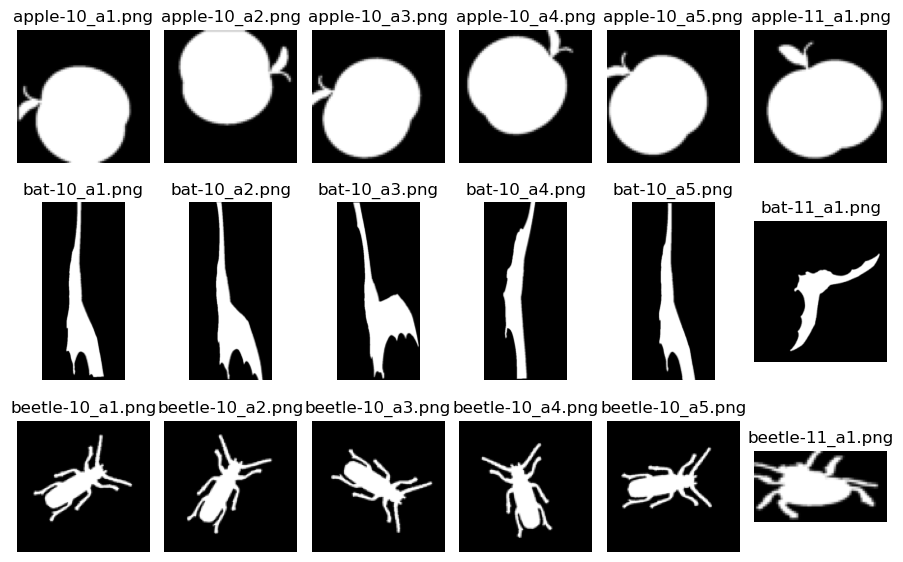

In [10]:
# Limita as listas a, no máximo, 18 elementos
seg_list_temp = seg_list_temp[:18]
filename_list_temp = filename_list_temp[:18]

# Calcula o número de linhas e colunas na grade (3x6 no caso de 18 imagens)
rows, cols = 3, 6

# Cria a figura com a grade
fig, ax = plt.subplots(rows, cols, figsize=(9, 6))

# Garante que 'ax' seja sempre um array bidimensional
ax = ax.reshape(rows, cols)

# Itera pelas imagens e nomes, organizando na grade
for i, (image, filename) in enumerate(zip(seg_list_temp, filename_list_temp)):
    row, col = divmod(i, cols)  # Calcula a posição na grade
    ax[row, col].imshow(image, cmap='gray')  # Exibe a imagem
    ax[row, col].set_title(str(filename))    # Define o título
    ax[row, col].axis('off')                 # Remove os eixos

# Remove os subplots vazios, se existirem
for i in range(len(seg_list_temp), rows * cols):
    row, col = divmod(i, cols)
    fig.delaxes(ax[row, col])  # Remove o eixo vazio

# Ajusta o layout da figura
fig.tight_layout()
plt.show()


## Making an Engineering Features

C:\Users\marcu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\marcu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\marcu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\marcu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

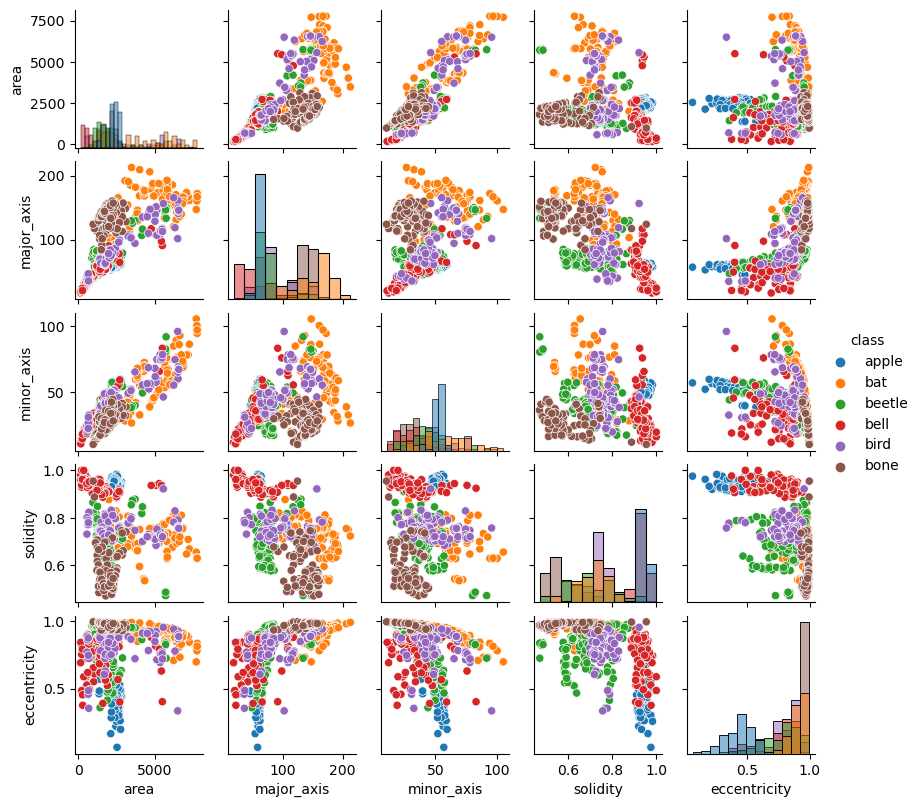

In [11]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Using area and solidity for classification

In [12]:
import numpy as np

# Converte feature_mat para um array NumPy
feature_mat_np = np.array(feature_mat)

# Seleciona apenas as duas primeiras características (Área e maior eixo)
feature_mat_ok = feature_mat_np[:, [0, 3]]

# Exibe as características selecionadas
print(feature_mat_ok)


[[2.08800000e+03 9.42238267e-01]
 [2.08600000e+03 9.34169279e-01]
 [2.11400000e+03 9.48833034e-01]
 ...
 [1.98200000e+03 5.13870884e-01]
 [2.12400000e+03 5.27701863e-01]
 [2.28100000e+03 5.45693780e-01]]


## Validação cruzada - Hold-out

In [13]:
# Separa o conjunto de dados em 'feature_map_ok', de acordo com 'label_list'. 
# 30% das imagens vão para o conjunto de testes.
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_mat_ok, 
                                                                    filtered_labels, 
                                                                    test_size=0.3, 
                                                                    random_state=42,
                                                                    stratify=filtered_labels
                                                                   )

## Normalizing data

In [14]:
# Média das caracteristicas do conjunto de treinamento
X_train_mean = X_train.mean(0)
# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_std = X_train.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train.mean(0))
    print(X_train.std(0))

[2627.331     0.7725]
[1683.4924    0.144 ]


In [15]:
# Transformada Normal de Caracteristicas
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

with np.printoptions(precision=4, suppress=True):
    print(X_train_norm.mean(0))
    print(X_test_norm.mean(0))

[-0. -0.]
[-0.0396 -0.0086]


## Executing K-nn

In [16]:
# Constrói um classificador do tipo K-NN
# K = 3
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)

In [17]:
# Acertos
acertos = y_test == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_test)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['bird' 'beetle' 'bell' 'bone' 'bat' 'apple' 'apple' 'beetle' 'bell'
 'bone' 'bat' 'bat' 'bat' 'bone' 'apple' 'bone' 'bird' 'apple' 'apple'
 'beetle' 'bone' 'bird' 'apple' 'beetle' 'bell' 'bone' 'apple' 'bird'
 'apple' 'bone' 'bell' 'bone' 'beetle' 'bird' 'bat' 'bird' 'bird' 'bell'
 'apple' 'bell' 'apple' 'bell' 'bird' 'bat' 'bell' 'bat' 'beetle' 'apple'
 'bird' 'bell' 'apple' 'bell' 'bird' 'bird' 'apple' 'apple' 'apple' 'bell'
 'bird' 'bird' 'apple' 'bell' 'beetle' 'bird' 'beetle' 'bird' 'beetle'
 'bat' 'bell' 'bone' 'apple' 'bell' 'bird' 'bell' 'bat' 'beetle' 'bone'
 'beetle' 'bat' 'bat' 'bird' 'apple' 'bell' 'apple' 'bell' 'bird' 'bat'
 'bird' 'bone' 'beetle' 'apple' 'bird' 'apple' 'bird' 'bell' 'bat' 'bat'
 'bat' 'beetle' 'bell' 'bat' 'beetle' 'bat' 'beetle' 'bone' 'bone'
 'beetle' 'beetle' 'bird' 'apple' 'bird' 'apple' 'apple' 'bird' 'bone'
 'beetle' 'bone' 'bone' 'apple' 'bird' 'bone' 'bird' 'apple' 'apple'
 'bird' 'bell' 'bat' 'apple' 'bat' 'bell' 'bell' 'bird' 'beet

## Making Confusion Matrix

In [18]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_test, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_test, pred))


Matriz de confusão:
[[29  0  0  1  0  0]
 [ 0 22  0  0  8  0]
 [ 0  0 23  0  5  2]
 [ 4  0  0 26  0  0]
 [ 0  7  2  0 21  0]
 [ 0  0  4  0  1 25]]

Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.88      0.97      0.92        30
         bat       0.76      0.73      0.75        30
      beetle       0.79      0.77      0.78        30
        bell       0.96      0.87      0.91        30
        bird       0.60      0.70      0.65        30
        bone       0.93      0.83      0.88        30

    accuracy                           0.81       180
   macro avg       0.82      0.81      0.81       180
weighted avg       0.82      0.81      0.81       180



## Executing SVC

In [19]:
# Instanciando o classificador SVM
clf_svm = SVC(kernel='rbf', C=1)  # Usando um kernel linear e parâmetro C = 1

# Treinando o classificador SVM
clf_svm.fit(X_train_norm, y_train)

# Testando o classificador SVM
pred_svm = clf_svm.predict(X_test_norm)

# Imprimindo a acurácia
accuracy = accuracy_score(y_test, pred_svm)
print(f'Acurácia: {accuracy:.2f}')

# Imprimindo o relatório de classificação (precisão, recall, f1-score)
print('\nRelatório de Classificação:')
print(classification_report(y_test, pred_svm, target_names=['apple', 'bat', 'beetle', 'bell', 'bird', 'bone']))

# Imprimindo a matriz de confusão
conf_matrix = confusion_matrix(y_test, pred_svm)
print('\nMatriz de Confusão:')
print(conf_matrix)



Acurácia: 0.70

Relatório de Classificação:
              precision    recall  f1-score   support

       apple       0.88      0.93      0.90        30
         bat       0.64      0.77      0.70        30
      beetle       0.52      0.43      0.47        30
        bell       0.93      0.87      0.90        30
        bird       0.48      0.53      0.51        30
        bone       0.77      0.67      0.71        30

    accuracy                           0.70       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.70      0.70      0.70       180


Matriz de Confusão:
[[28  0  0  2  0  0]
 [ 0 23  0  0  7  0]
 [ 0  2 13  0  9  6]
 [ 4  0  0 26  0  0]
 [ 0 10  4  0 16  0]
 [ 0  1  8  0  1 20]]
